Introduction
Porto Seguro Auto

This notebook starts by giving an introduction in the data of Porto Seguro competition. Then follows with preparing and running few predictive models using cross-validation and stacking and prepares a submission.

The notebook is using elements from the following kernels:

Data Preparation and Exploration by Bert Carremans.
Steering Whell of Fortune - Porto Seguro EDA by Heads or Tails
Interactive Porto Insights - A Plot.ly Tutorial by Anisotropic
Simple Stacker by Vladimir Demidov

포루투 데이터 - Porto Seguro competition 

Porto Seguro는 브라질의 자동차 보험 회사 
 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 것

교차 검증을 통해 예측해보고자 한다.
뭐 밑에는 도움되는 커널이라는 뜻 (참조)


# Analysis packages

In [2]:
pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#싸이킷런 
from sklearn.utils import shuffle #셔플 
#결측치 보간 from sklearn.preprocessing import Imputer was deprecated with scikit-learn v0.20.4 and removed as of v0.22.2
# from sklearn.preprocessing import Imputer  
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures 
#다항회귀 , / 다항회귀란 위와 같이 데이터들간의 형태가 비선형 일때 데이터에 각 특성의 제곱을 추가해주어서 특성이 추가된 비선형 데이터를 선형 회귀 모델로 훈련시키는 방법
from sklearn.preprocessing import StandardScaler #정규화 - 스탠다드 스칼라
# 분산에 따라 분산이 기준치보다 낮으면 삭제하는 VarianceThreshold
from sklearn.feature_selection import VarianceThreshold 
#트리 기반 모델(또는 선형모델)들이 특성 중요도(Feature Importance)를 제공하는 것에 기반한 방법입니다. 
#특성 중요도는 예측의 불확실성을 낮출수록 증가하므로, 
#(X,y)를 트리 기반 모델에 학습시킨 뒤, 특성 중요도가 기준치보다 높은 특성을 선택하는 방법입니다. 
#특성 선택에 사용한 모델과, 최종 예측 모델은 다를 수 있습니다.
from sklearn.feature_selection import SelectFromModel
#계층 k 폴드 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
#사용할 모델
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

Load the data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
trainset = pd.read_csv('/content/drive/MyDrive/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/test.csv')

In [5]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [8]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [7]:
trainset.shape, testset.shape

((595212, 59), (892816, 58))

Few quick observations
We can make few observations based on the data description in the competition:

Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-explanatory, calc suggests a calculated field;
The postfix bin is used for binary features;
The postfix cat to is used for categorical features;
Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
A missing value is indicated by -1;
The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
id is a data input ordinal number.
Let's glimpse the data to see if these interpretations are confirmed.

(번역기 돌림)
몇 가지 빠른 관찰
대회의 데이터 설명을 기반으로 몇 가지 관찰을 할 수 있습니다.

정의된 그룹은 거의 없으며 이러한 그룹에 속하는 기능에는 이름에 패턴이 포함됩니다(ind, reg, car, calc). ind는 아마도 개인을 나타내고, reg는 아마도 등록, car는 자명한 설명, calc는 계산된 필드를 나타냅니다.
접미사 bin은 바이너리 기능에 사용됩니다.
cat to 접미사는 범주형 기능에 사용됩니다.
bin 또는 cat 표시가 없는 기능은 정수(서수 값)의 실수(연속 값)입니다.
누락된 값은 -1로 표시됩니다.
예측 대상 값이 대상 열에 있습니다. 이것은 해당 피보험자에 대한 청구가 접수되었는지 여부를 나타냅니다.
id는 데이터 입력 서수입니다.
이러한 해석이 사실인지 확인하기 위해 데이터를 살펴보자.

In [9]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


In [10]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


1. MetaData

이번 커널에서 처음 본 특징이다.
MetaData는 features들에 대한 정보라고 이해하면 편하다.
즉, features 의 특징을 저장하고 이를 바탕으로 feature engineering한다.
여기서는 다음 특징들로 features들을 구분한다.

- role : input, Id, target
- level: nominal, interval, ordinal, binary
- keep : True or False
- dytpe: int, str, float


데이터의 시각화, 분석, 모델링 위해 모델의 메타데이터를 데이터프레임에 저장함

role: input, ID, target

level: nominal, interval, ordinal, binary

keep: True or False

dtype: int, float, str

In [11]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 특성들을 보고 범주 고유 값이 몇 개인지 확인합니다.

In [12]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


20개의 계산된 특성들, 16개의 자동차, 18개의 개인 및 3개의 등록이 있습니다.

이제 모든 특성들을 보고 얼마나 많은 사용 및 유형 고유 값이 있는지 확인하겠습니다.

In [13]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


하나의 명목 특성(id), 

20개의 이진 값, 

21개의 실수(또는 부동 소수점 수), 

16개의 카테고리  특성이 있습니다. 이 모든 기능은 입력 값과 하나의 대상 값이며 이진 값인 대상입니다.

Target variable

<Figure size 432x288 with 0 Axes>

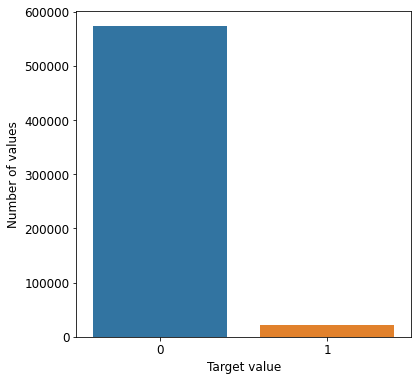

In [14]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

대상 데이터의 3.64%만이 1개의 값을 갖습니다. 이는 훈련 데이터 세트의 불균형이 매우 높음을 의미합니다. target = 0인 레코드를 언더샘플링하거나 target = 1인 레코드를 오버샘플링할 수 있습니다. 가 큰 데이터 세트이기 때문에 target = 0인 레코드의 언더샘플링을 수행합니다.

UnderSampling

UnderSampling은 많은 부분을 차지하는 세트에 적은 부분을 차지하는 세트 수준으로 감소시키는 방법이다.

물론, overfitting 문제를 해결할 수는 있지만, 중요한 데이터가 삭제될 위험이 있다.

In [19]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [20]:
metadata.isnull().sum()

use         0
type        0
preserve    0
dtype       0
category    0
dtype: int64

In [22]:
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [23]:
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

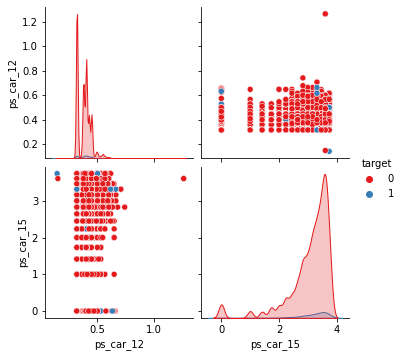

In [21]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

계산된 기능
ps_calc_01, ps_calc_02 및 ps_calc_03 기능은 매우 유사한 분포를 가지며 최대값이 세 가지 모두에 대한 0.9이기 때문에 일종의 비율이 될 수 있습니다. 다른 계산된 값은 최대값이 정수 값(5,6,7, 10,12)입니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

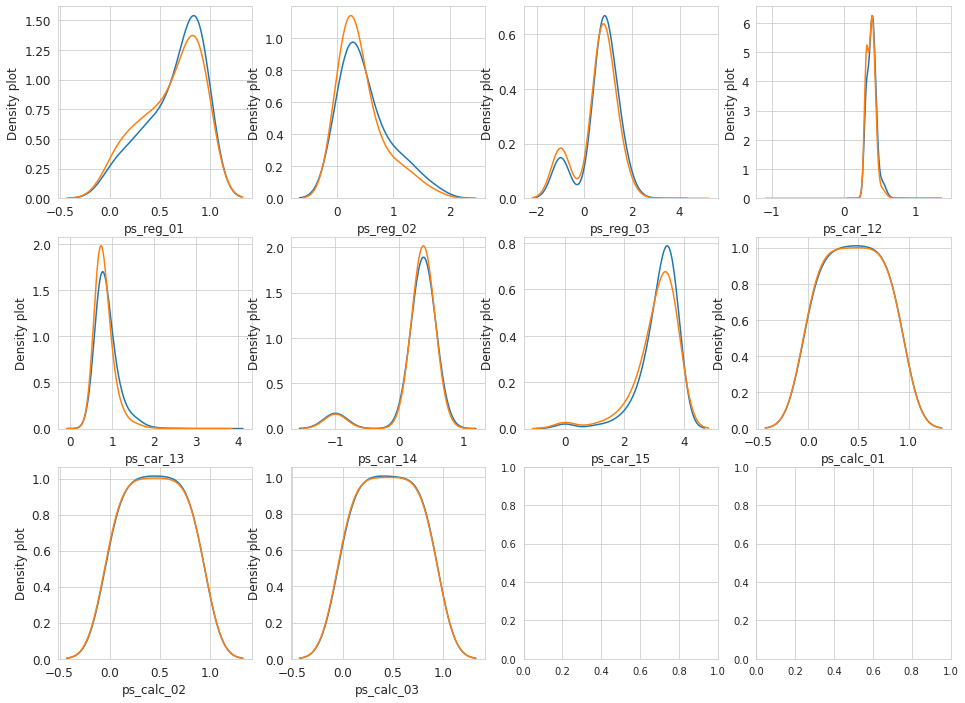

In [24]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

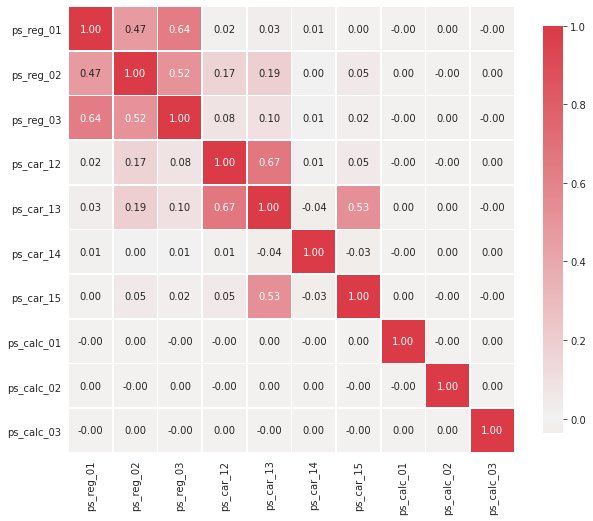

In [25]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

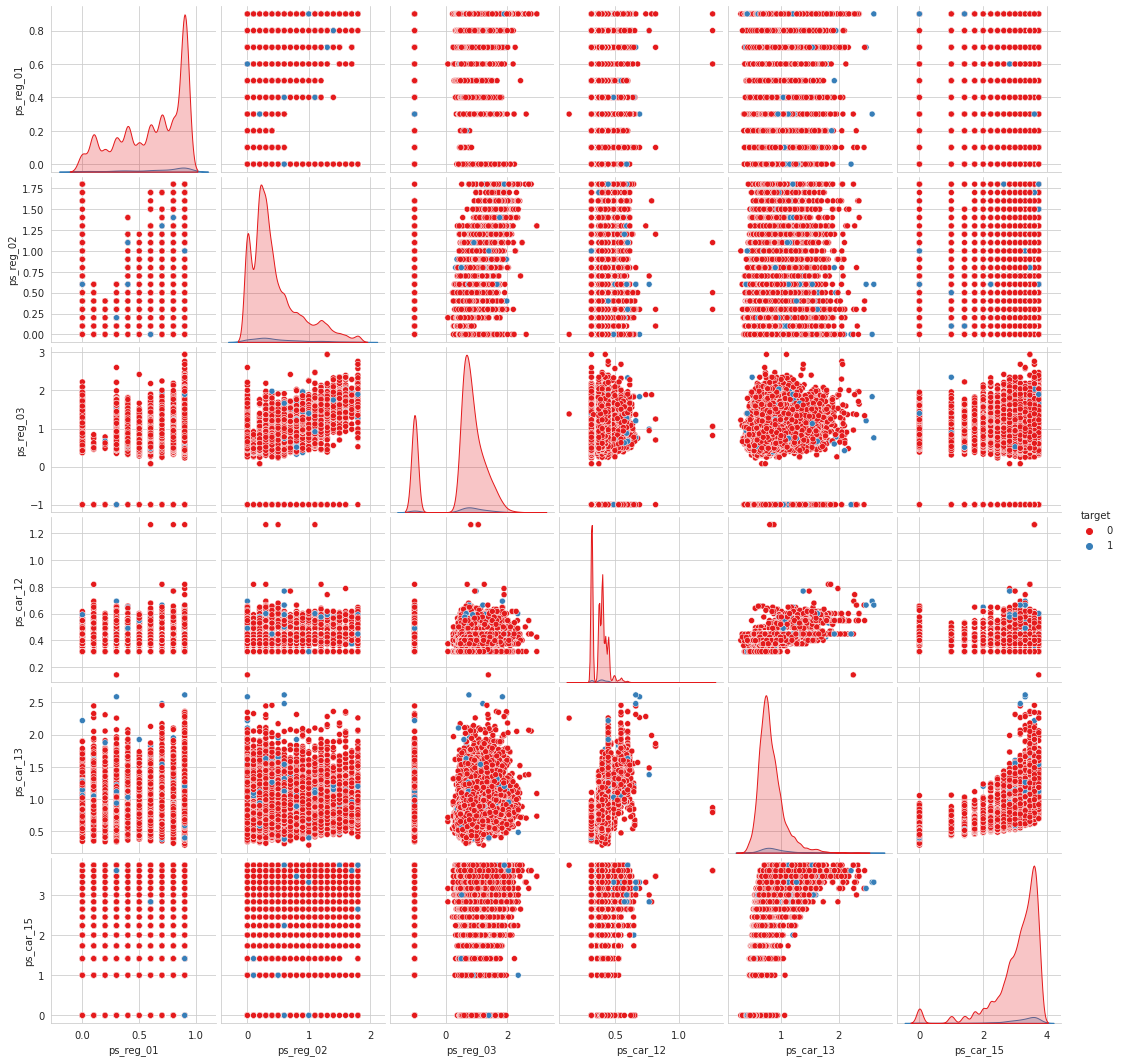

In [26]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

범주형 데이터에 대한 분포를 두 가지 방법으로 나타낼 것입니다. 먼저 범주 값당 target=1의 백분율을 계산하고 막대 그림을 사용하여 이러한 백분율을 나타냅니다.

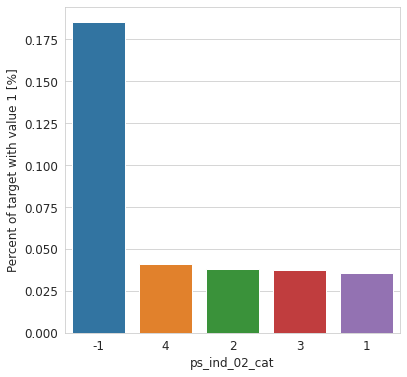

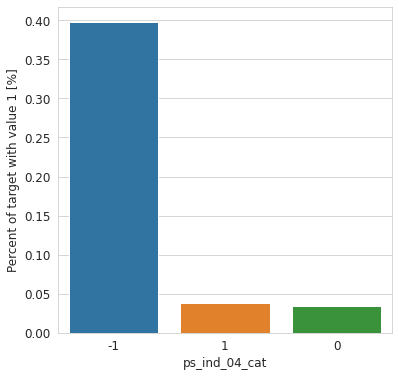

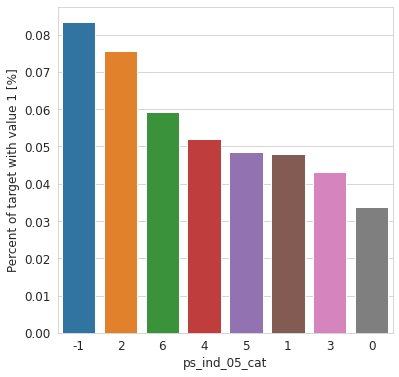

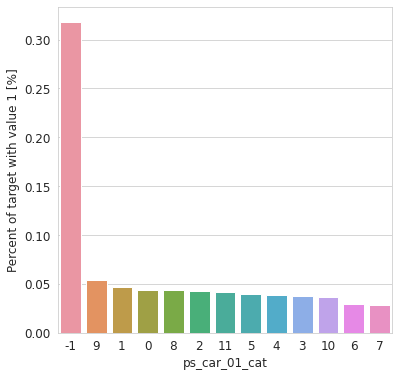

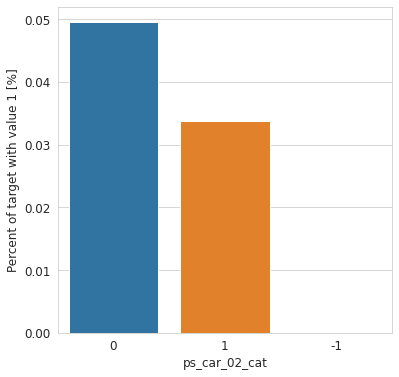

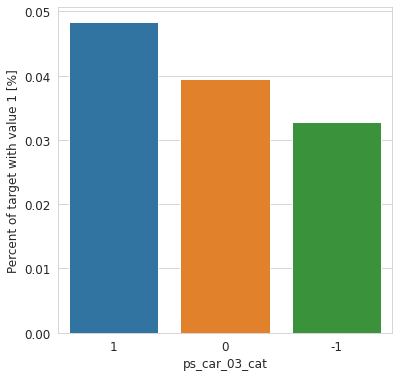

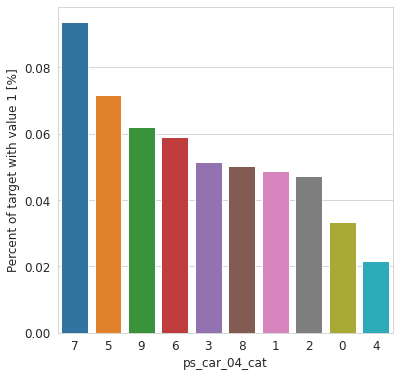

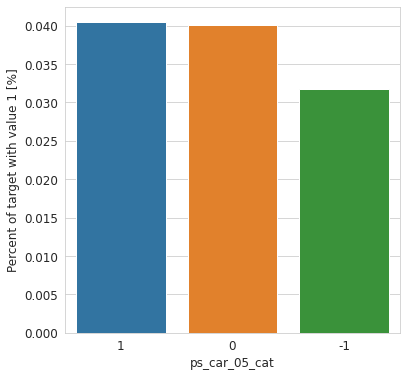

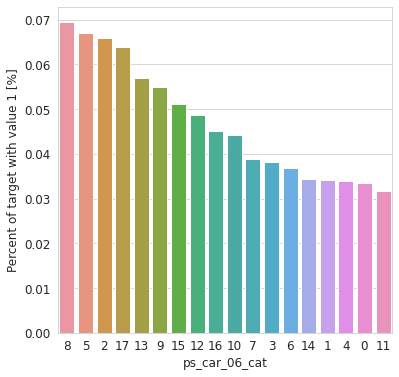

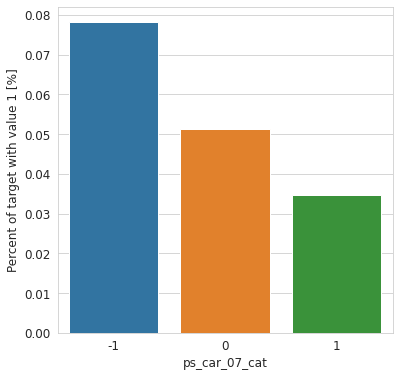

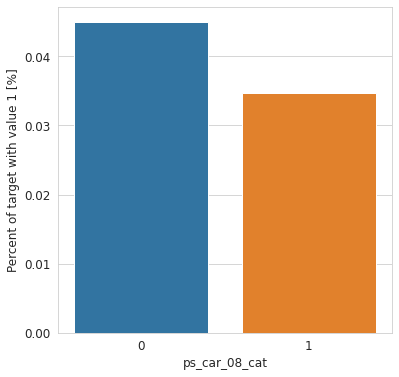

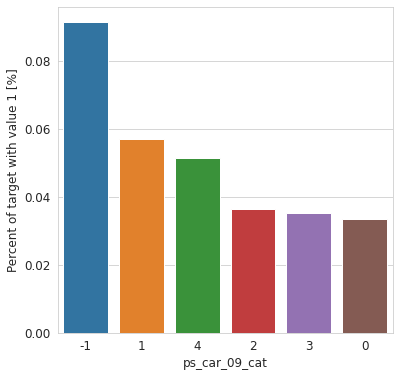

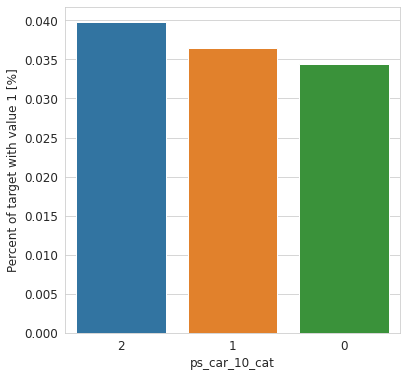

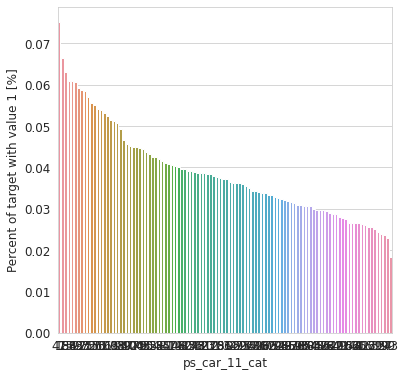

In [27]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    
    # Order the bars descending on target mean
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

결측치를 봅니다

In [28]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


Drop calc columns 이것들은 모두 조작된 것으로 보이며 Dmitry Altukhov에 따르면 CV 점수를 향상시키면서 모든 항목을 성공적으로 제거할 수 있었습니다.

In [29]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

Drop variables with too many missing values
We select from the variables with missing values two, ps_car_03_cat and ps_car_05_cat to drop.



In [30]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False  # Updating the meta

In [31]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

ps_car_11_cat을 인코딩된 값으로 바꿉니다.
target_encode 함수를 사용하여 ps_car_11_cat을 훈련 데이터 세트와 테스트 데이터 세트 모두에서 인코딩된 값으로 바꿉니다.

In [32]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

균형 목표 변수

대상 변수가 매우 불균형합니다. 

이는 target = 0인 언더샘플링 값 또는 target = 1인 오버샘플링 값으로 개선할 수 있습니다.

 다소 큰 훈련 세트가 있기 때문에 언더샘플링을 선택합니다.

In [33]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


UnderSampling은 많은 부분을 차지하는 세트에 적은 부분을 차지하는 세트 수준으로 감소시키는 방법이다.
물론, overfitting 문제를 해결할 수는 있지만, 중요한 데이터가 삭제될 위험이 있다.

Replace -1 values with NaN
Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.

In [35]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

Dummify cat values


We will create dummy variables for the categorical (cat) features

In [36]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

Drop unused and target columns

We separate the id and target (drop these columns)

In [37]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

In [38]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


교차 검증 및 앙상블을 위한 클래스 활성화
Ensamble 클래스를 준비하여 KFolds의 데이터를 분할하고, 모델을 훈련하고, 결과를 엔앰블합니다.

클래스에는 4개의 매개변수를 허용하는 init 메소드(Ensamble 객체가 생성될 때 호출됨)가 있습니다.

self - 초기화되는 객체

n_splits - 사용할 교차 검증 분할 수

stacker - 훈련된 기본 모델의 예측 결과를 쌓는 데 사용되는 모델

base_models - 훈련에 사용된 기본 모델 목록

두 번째 방법인 fit_predict에는 네 가지 기능이 있습니다.

훈련 데이터를 n_splits 폴드로 분할합니다.

각 접기에 대해 기본 모델을 실행합니다.
각 모델을 사용하여 예측을 수행합니다.
스태커를 사용하여 결과를 엔앰블링합니다.

In [39]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))
        #영행렬 만들기
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        #for 문 돌면서 쌓임
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

기본 모델에 대한 매개변수
기본 모델의 경우 3가지 다른 LightGBM 모델과 1개의 XGB 모델을 준비합니다.

각 모델은 데이터를 훈련하는 데 사용됩니다(3겹으로 교차 검증도 사용).

앙상블에 앙상블에 앙상블


랜덤서치 , 그리드서치 ,유전자알고리즘,,?

In [40]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

Initialize the models with the parameters
We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.

스태커 로지스틱 리그레션으로 사용 

In [41]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [42]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

Run the predictive models
Calling the fit_predict method of stack object, we run the training of the base models, predict the target with each model, ensamble the results using the stacker model and output the stacked result.

In [43]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63746 [gini]: 0.27491
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63900 [gini]: 0.27800
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63548 [gini]: 0.27096
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63965 [gini]: 0.27931
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.64057 [gini]: 0.28114
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63714 [gini]: 0.27429
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63644 [gini]: 0.27289
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63712 [gini]: 0.27425
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63465 [gini]: 0.26931
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63866 [gini]: 0.27731
Base model 4: fit XGBClassifier model | fold 2
cros

Prepare the submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)